In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torch
import time
import numpy as np
from torch import nn
from torch.nn import functional as F
import torchvision
import matplotlib.pyplot as plt

In [2]:
torch.autograd.set_detect_anomaly(True)

In [3]:
import dlc_practical_prologue as prologue

In [4]:
# load training and testing data
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

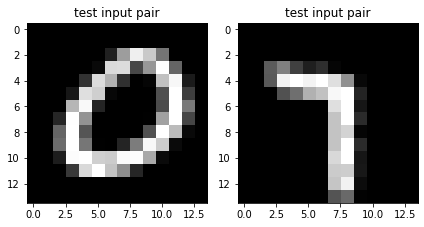

The test classes are: 0 and 7.
The test target is: 0


In [5]:
# discribe the data
fig = plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(test_input[0][i], cmap='gray')
  plt.title("test input pair")  
  plt.tight_layout()
plt.show()
print("The test classes are: %d and %d."%(test_classes[0][0].item(),test_classes[0][1].item()))
print("The test target is: %d"%(train_target[0]))

In [6]:
class residual_block(nn.Module):
    def __init__(self,input_channels,num_channels,use_one_conv=True):
        super().__init__()
        self.use_one_conv=use_one_conv
        self.conv1 = nn.Conv2d(input_channels,num_channels, kernel_size=3,padding=1,stride=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1,stride=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
        if self.use_one_conv:
            self.conv3 = nn.Conv2d(input_channels,num_channels,kernel_size=1,stride=1)
    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)
        if self.use_one_conv:
            x = self.conv3(x)  
            out=x+out
        return out

In [14]:
# Now we are going to build a ResNet, which is the stack of residual block.
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.block1=nn.Conv2d(2,32,7,2)
        self.block2 = nn.Sequential(
            nn.MaxPool2d(3, 2),
            residual_block(32, 32),
            residual_block(32, 32)
        )
        self.block3 = nn.Sequential(
            residual_block(32, 64, False),
            residual_block(64, 64)
        )
        self.block4 = nn.Sequential(
            residual_block(64, 128, False),
            residual_block(128, 128)
        )

        self.block5 = nn.Sequential(
            residual_block(128, 256, False),
            residual_block(256, 256),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 2)
        
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x=x.view(-1, 256)        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # Training Function
    def trainer(self, train_input, train_target, test_input, test_target):
        """
        Train the model on a training set, and plot the loss and accuracy function
        Print the used time.
        :param train_input: Training input data
        :param train_target: Training labels
        :param test_input: Testing input data
        :param test_target: Testing labels
        """
        start_time = time.time()
        train_loss_history=[]
        test_loss_history=[]
        train_accuracy=[]
        test_accuracy=[]
        for epoch in range(self.num_epochs):
            self.train()
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output = self(train_input[batch_idx:batch_idx+self.batch_size]) 
                loss = self.criterion(output, train_target[batch_idx:batch_idx+self.batch_size])  
                self.optimizer.zero_grad()                          #set the weight and bias gradients to zero
                loss.backward()                                #backpropagation
                self.optimizer.step()
#                 # print the loss in every 50 epoch
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
            # test mode
            self.eval()
            # get the training loss and accuracy
            train_predicted = self(train_input)
            train_loss = self.criterion(train_predicted, train_target)
            train_loss_history.append(train_loss)
            _, train_pred = torch.max(train_predicted, 1)   #return the index of the bigger result
            train_accuracy_result=self.compute_accuracy(train_target,train_pred)
            train_accuracy.append(train_accuracy_result)

            # get the testing loss and accuracy
            test_predicted = self(test_input)
            test_loss = self.criterion(test_predicted, test_target)
            test_loss_history.append(test_loss)
            _, test_pred = torch.max(test_predicted, 1)   #return the index of the bigger result
            test_accuracy_result=self.compute_accuracy(test_target,test_pred)
            test_accuracy.append(test_accuracy_result)
            
        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        
        #Setting-up the plot
        plt.figure(figsize=(15,8))

        ax1 = plt.subplot(1,2,1)

        ax2 = plt.subplot(1,2,2)

        #Drawing and labeling the curves
        ax1.plot(train_loss_history, label="Training Loss")
        ax1.plot(test_loss_history, label="Test Loss")

        #Adding the title and axis labels
        ax1.set_title('Train VS Test Loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()

    #     #Saving the plot
    #     ax1.figure.savefig(model.model_name+'loss.png')


        #Drawing and labeling the curves
        ax2.plot(train_accuracy, label="Train Accuracy")
        ax2.plot(test_accuracy, label="Test Accuracy")

        #Adding the title and axis labels
        ax2.set_title('Train VS Test Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
    
        #test mode
        self.eval()
        outputs= self(input_data)
        _, predicted = torch.max(outputs, 1)
        return 1-self.compute_accuracy(target,predicted)
    
    def compute_accuracy(self, target, pred):
        """
        Compute the training and testing error
        :param target: target data (whether 1 or 0)
        :param pred: predicted data
        :return 
        """
        return (target-pred).eq(0).float().mean().item()
    
    
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+ model_name)        

In [15]:
# build the net instance
my_model=ResNet()
# save the model
my_model.save_model('ResNet.pth')

Epoch: 001/025 | Batch 000/1000 | Loss: 0.702402
Epoch: 001/025 | Batch 050/1000 | Loss: 0.722455
Epoch: 001/025 | Batch 100/1000 | Loss: 0.654407
Epoch: 001/025 | Batch 150/1000 | Loss: 0.776142
Epoch: 001/025 | Batch 200/1000 | Loss: 0.746637
Epoch: 001/025 | Batch 250/1000 | Loss: 0.804422
Epoch: 001/025 | Batch 300/1000 | Loss: 0.819753
Epoch: 001/025 | Batch 350/1000 | Loss: 0.669226
Epoch: 001/025 | Batch 400/1000 | Loss: 0.714128
Epoch: 001/025 | Batch 450/1000 | Loss: 0.707085
Epoch: 001/025 | Batch 500/1000 | Loss: 0.717476
Epoch: 001/025 | Batch 550/1000 | Loss: 0.699209
Epoch: 001/025 | Batch 600/1000 | Loss: 0.703300
Epoch: 001/025 | Batch 650/1000 | Loss: 0.674298
Epoch: 001/025 | Batch 700/1000 | Loss: 0.677122
Epoch: 001/025 | Batch 750/1000 | Loss: 0.685573
Epoch: 001/025 | Batch 800/1000 | Loss: 0.673519
Epoch: 001/025 | Batch 850/1000 | Loss: 0.721789
Epoch: 001/025 | Batch 900/1000 | Loss: 0.636350
Epoch: 001/025 | Batch 950/1000 | Loss: 0.665655
Time elapsed: 0.04 m

Epoch: 009/025 | Batch 200/1000 | Loss: 0.173466
Epoch: 009/025 | Batch 250/1000 | Loss: 0.119541
Epoch: 009/025 | Batch 300/1000 | Loss: 0.219296
Epoch: 009/025 | Batch 350/1000 | Loss: 0.262068
Epoch: 009/025 | Batch 400/1000 | Loss: 0.443726
Epoch: 009/025 | Batch 450/1000 | Loss: 0.335719
Epoch: 009/025 | Batch 500/1000 | Loss: 0.439488
Epoch: 009/025 | Batch 550/1000 | Loss: 0.176057
Epoch: 009/025 | Batch 600/1000 | Loss: 0.205680
Epoch: 009/025 | Batch 650/1000 | Loss: 0.187664
Epoch: 009/025 | Batch 700/1000 | Loss: 0.403526
Epoch: 009/025 | Batch 750/1000 | Loss: 0.243256
Epoch: 009/025 | Batch 800/1000 | Loss: 0.166146
Epoch: 009/025 | Batch 850/1000 | Loss: 0.116163
Epoch: 009/025 | Batch 900/1000 | Loss: 0.303729
Epoch: 009/025 | Batch 950/1000 | Loss: 0.162750
Time elapsed: 0.40 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.295896
Epoch: 010/025 | Batch 050/1000 | Loss: 0.289225
Epoch: 010/025 | Batch 100/1000 | Loss: 0.186156
Epoch: 010/025 | Batch 150/1000 | Loss: 0.1957

Epoch: 017/025 | Batch 400/1000 | Loss: 0.053985
Epoch: 017/025 | Batch 450/1000 | Loss: 0.057377
Epoch: 017/025 | Batch 500/1000 | Loss: 0.098628
Epoch: 017/025 | Batch 550/1000 | Loss: 0.004849
Epoch: 017/025 | Batch 600/1000 | Loss: 0.077558
Epoch: 017/025 | Batch 650/1000 | Loss: 0.005896
Epoch: 017/025 | Batch 700/1000 | Loss: 0.005824
Epoch: 017/025 | Batch 750/1000 | Loss: 0.052570
Epoch: 017/025 | Batch 800/1000 | Loss: 0.011867
Epoch: 017/025 | Batch 850/1000 | Loss: 0.128114
Epoch: 017/025 | Batch 900/1000 | Loss: 0.012834
Epoch: 017/025 | Batch 950/1000 | Loss: 0.063088
Time elapsed: 0.75 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.041377
Epoch: 018/025 | Batch 050/1000 | Loss: 0.050589
Epoch: 018/025 | Batch 100/1000 | Loss: 0.066110
Epoch: 018/025 | Batch 150/1000 | Loss: 0.014416
Epoch: 018/025 | Batch 200/1000 | Loss: 0.026089
Epoch: 018/025 | Batch 250/1000 | Loss: 0.025003
Epoch: 018/025 | Batch 300/1000 | Loss: 0.013997
Epoch: 018/025 | Batch 350/1000 | Loss: 0.0278

Epoch: 025/025 | Batch 600/1000 | Loss: 0.089890
Epoch: 025/025 | Batch 650/1000 | Loss: 0.074709
Epoch: 025/025 | Batch 700/1000 | Loss: 0.004312
Epoch: 025/025 | Batch 750/1000 | Loss: 0.003379
Epoch: 025/025 | Batch 800/1000 | Loss: 0.010942
Epoch: 025/025 | Batch 850/1000 | Loss: 0.003521
Epoch: 025/025 | Batch 900/1000 | Loss: 0.003278
Epoch: 025/025 | Batch 950/1000 | Loss: 0.013248
Time elapsed: 1.10 min
Total Training Time: 1.11 min


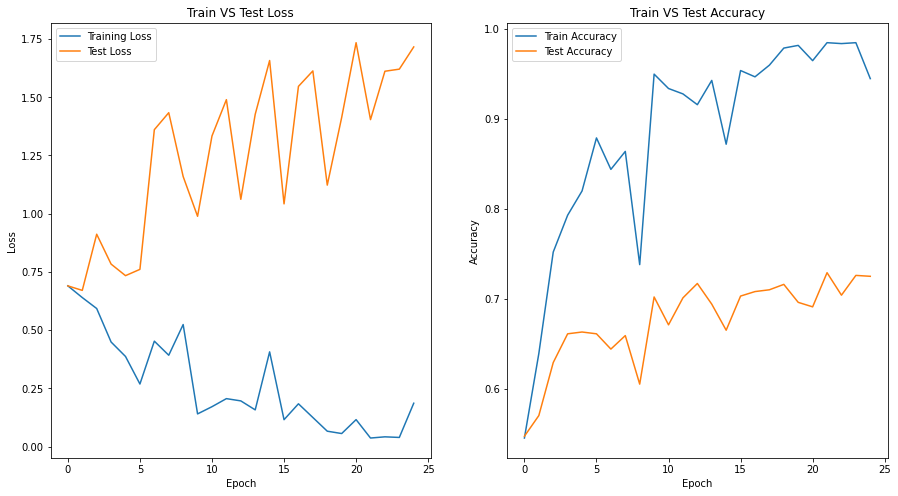

In [16]:
# train the model
my_model.trainer(train_input, train_target, test_input, test_target)

In [17]:
# output the total number of parameters
print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

The total number of the parameters is: 2877026


Epoch: 001/025 | Batch 000/1000 | Loss: 0.703906
Epoch: 001/025 | Batch 050/1000 | Loss: 0.669009
Epoch: 001/025 | Batch 100/1000 | Loss: 0.696654
Epoch: 001/025 | Batch 150/1000 | Loss: 0.812540
Epoch: 001/025 | Batch 200/1000 | Loss: 0.678044
Epoch: 001/025 | Batch 250/1000 | Loss: 0.652356
Epoch: 001/025 | Batch 300/1000 | Loss: 0.718045
Epoch: 001/025 | Batch 350/1000 | Loss: 0.664638
Epoch: 001/025 | Batch 400/1000 | Loss: 0.689609
Epoch: 001/025 | Batch 450/1000 | Loss: 0.701735
Epoch: 001/025 | Batch 500/1000 | Loss: 0.719308
Epoch: 001/025 | Batch 550/1000 | Loss: 0.670044
Epoch: 001/025 | Batch 600/1000 | Loss: 0.723822
Epoch: 001/025 | Batch 650/1000 | Loss: 0.690959
Epoch: 001/025 | Batch 700/1000 | Loss: 0.673425
Epoch: 001/025 | Batch 750/1000 | Loss: 0.667036
Epoch: 001/025 | Batch 800/1000 | Loss: 0.737485
Epoch: 001/025 | Batch 850/1000 | Loss: 0.725223
Epoch: 001/025 | Batch 900/1000 | Loss: 0.662752
Epoch: 001/025 | Batch 950/1000 | Loss: 0.666789
Time elapsed: 0.04 m

Epoch: 009/025 | Batch 200/1000 | Loss: 0.412232
Epoch: 009/025 | Batch 250/1000 | Loss: 0.258208
Epoch: 009/025 | Batch 300/1000 | Loss: 0.278734
Epoch: 009/025 | Batch 350/1000 | Loss: 0.268708
Epoch: 009/025 | Batch 400/1000 | Loss: 0.292455
Epoch: 009/025 | Batch 450/1000 | Loss: 0.261133
Epoch: 009/025 | Batch 500/1000 | Loss: 0.452958
Epoch: 009/025 | Batch 550/1000 | Loss: 0.348526
Epoch: 009/025 | Batch 600/1000 | Loss: 0.344067
Epoch: 009/025 | Batch 650/1000 | Loss: 0.229573
Epoch: 009/025 | Batch 700/1000 | Loss: 0.418056
Epoch: 009/025 | Batch 750/1000 | Loss: 0.305618
Epoch: 009/025 | Batch 800/1000 | Loss: 0.343790
Epoch: 009/025 | Batch 850/1000 | Loss: 0.252341
Epoch: 009/025 | Batch 900/1000 | Loss: 0.204160
Epoch: 009/025 | Batch 950/1000 | Loss: 0.178671
Time elapsed: 0.40 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.193929
Epoch: 010/025 | Batch 050/1000 | Loss: 0.188603
Epoch: 010/025 | Batch 100/1000 | Loss: 0.145247
Epoch: 010/025 | Batch 150/1000 | Loss: 0.2950

Epoch: 017/025 | Batch 400/1000 | Loss: 0.017877
Epoch: 017/025 | Batch 450/1000 | Loss: 0.029246
Epoch: 017/025 | Batch 500/1000 | Loss: 0.115277
Epoch: 017/025 | Batch 550/1000 | Loss: 0.030767
Epoch: 017/025 | Batch 600/1000 | Loss: 0.034400
Epoch: 017/025 | Batch 650/1000 | Loss: 0.116204
Epoch: 017/025 | Batch 700/1000 | Loss: 0.013124
Epoch: 017/025 | Batch 750/1000 | Loss: 0.020676
Epoch: 017/025 | Batch 800/1000 | Loss: 0.143246
Epoch: 017/025 | Batch 850/1000 | Loss: 0.006956
Epoch: 017/025 | Batch 900/1000 | Loss: 0.042691
Epoch: 017/025 | Batch 950/1000 | Loss: 0.112626
Time elapsed: 0.81 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.164997
Epoch: 018/025 | Batch 050/1000 | Loss: 0.008403
Epoch: 018/025 | Batch 100/1000 | Loss: 0.009181
Epoch: 018/025 | Batch 150/1000 | Loss: 0.029748
Epoch: 018/025 | Batch 200/1000 | Loss: 0.038308
Epoch: 018/025 | Batch 250/1000 | Loss: 0.173167
Epoch: 018/025 | Batch 300/1000 | Loss: 0.078219
Epoch: 018/025 | Batch 350/1000 | Loss: 0.0062

Epoch: 025/025 | Batch 600/1000 | Loss: 0.024914
Epoch: 025/025 | Batch 650/1000 | Loss: 0.144197
Epoch: 025/025 | Batch 700/1000 | Loss: 0.006868
Epoch: 025/025 | Batch 750/1000 | Loss: 0.006167
Epoch: 025/025 | Batch 800/1000 | Loss: 0.095755
Epoch: 025/025 | Batch 850/1000 | Loss: 0.018035
Epoch: 025/025 | Batch 900/1000 | Loss: 0.021013
Epoch: 025/025 | Batch 950/1000 | Loss: 0.007680
Time elapsed: 1.17 min
Total Training Time: 1.17 min
Epoch: 001/025 | Batch 000/1000 | Loss: 0.689275
Epoch: 001/025 | Batch 050/1000 | Loss: 0.685630
Epoch: 001/025 | Batch 100/1000 | Loss: 0.688490
Epoch: 001/025 | Batch 150/1000 | Loss: 0.670154
Epoch: 001/025 | Batch 200/1000 | Loss: 0.633880
Epoch: 001/025 | Batch 250/1000 | Loss: 0.618077
Epoch: 001/025 | Batch 300/1000 | Loss: 0.727947
Epoch: 001/025 | Batch 350/1000 | Loss: 0.743431
Epoch: 001/025 | Batch 400/1000 | Loss: 0.765088
Epoch: 001/025 | Batch 450/1000 | Loss: 0.682172
Epoch: 001/025 | Batch 500/1000 | Loss: 0.751703
Epoch: 001/025 |

Epoch: 008/025 | Batch 800/1000 | Loss: 0.126189
Epoch: 008/025 | Batch 850/1000 | Loss: 0.156502
Epoch: 008/025 | Batch 900/1000 | Loss: 0.334698
Epoch: 008/025 | Batch 950/1000 | Loss: 0.191243
Time elapsed: 0.36 min
Epoch: 009/025 | Batch 000/1000 | Loss: 0.149713
Epoch: 009/025 | Batch 050/1000 | Loss: 0.138073
Epoch: 009/025 | Batch 100/1000 | Loss: 0.254603
Epoch: 009/025 | Batch 150/1000 | Loss: 0.136393
Epoch: 009/025 | Batch 200/1000 | Loss: 0.079195
Epoch: 009/025 | Batch 250/1000 | Loss: 0.425056
Epoch: 009/025 | Batch 300/1000 | Loss: 0.253451
Epoch: 009/025 | Batch 350/1000 | Loss: 0.152100
Epoch: 009/025 | Batch 400/1000 | Loss: 0.318768
Epoch: 009/025 | Batch 450/1000 | Loss: 0.092983
Epoch: 009/025 | Batch 500/1000 | Loss: 0.250144
Epoch: 009/025 | Batch 550/1000 | Loss: 0.184083
Epoch: 009/025 | Batch 600/1000 | Loss: 0.178708
Epoch: 009/025 | Batch 650/1000 | Loss: 0.216220
Epoch: 009/025 | Batch 700/1000 | Loss: 0.160275
Epoch: 009/025 | Batch 750/1000 | Loss: 0.2592

Epoch: 017/025 | Batch 000/1000 | Loss: 0.092549
Epoch: 017/025 | Batch 050/1000 | Loss: 0.061155
Epoch: 017/025 | Batch 100/1000 | Loss: 0.052385
Epoch: 017/025 | Batch 150/1000 | Loss: 0.040396
Epoch: 017/025 | Batch 200/1000 | Loss: 0.044021
Epoch: 017/025 | Batch 250/1000 | Loss: 0.119897
Epoch: 017/025 | Batch 300/1000 | Loss: 0.052527
Epoch: 017/025 | Batch 350/1000 | Loss: 0.083236
Epoch: 017/025 | Batch 400/1000 | Loss: 0.057454
Epoch: 017/025 | Batch 450/1000 | Loss: 0.018791
Epoch: 017/025 | Batch 500/1000 | Loss: 0.123989
Epoch: 017/025 | Batch 550/1000 | Loss: 0.145469
Epoch: 017/025 | Batch 600/1000 | Loss: 0.015683
Epoch: 017/025 | Batch 650/1000 | Loss: 0.018064
Epoch: 017/025 | Batch 700/1000 | Loss: 0.018996
Epoch: 017/025 | Batch 750/1000 | Loss: 0.007497
Epoch: 017/025 | Batch 800/1000 | Loss: 0.050051
Epoch: 017/025 | Batch 850/1000 | Loss: 0.025260
Epoch: 017/025 | Batch 900/1000 | Loss: 0.060128
Epoch: 017/025 | Batch 950/1000 | Loss: 0.019691
Time elapsed: 0.79 m

Epoch: 025/025 | Batch 200/1000 | Loss: 0.051614
Epoch: 025/025 | Batch 250/1000 | Loss: 0.285864
Epoch: 025/025 | Batch 300/1000 | Loss: 0.186459
Epoch: 025/025 | Batch 350/1000 | Loss: 0.043831
Epoch: 025/025 | Batch 400/1000 | Loss: 0.053643
Epoch: 025/025 | Batch 450/1000 | Loss: 0.141411
Epoch: 025/025 | Batch 500/1000 | Loss: 0.029131
Epoch: 025/025 | Batch 550/1000 | Loss: 0.021445
Epoch: 025/025 | Batch 600/1000 | Loss: 0.039309
Epoch: 025/025 | Batch 650/1000 | Loss: 0.042877
Epoch: 025/025 | Batch 700/1000 | Loss: 0.051203
Epoch: 025/025 | Batch 750/1000 | Loss: 0.127867
Epoch: 025/025 | Batch 800/1000 | Loss: 0.022587
Epoch: 025/025 | Batch 850/1000 | Loss: 0.031506
Epoch: 025/025 | Batch 900/1000 | Loss: 0.072016
Epoch: 025/025 | Batch 950/1000 | Loss: 0.016200
Time elapsed: 1.15 min
Total Training Time: 1.15 min
Epoch: 001/025 | Batch 000/1000 | Loss: 0.701796
Epoch: 001/025 | Batch 050/1000 | Loss: 0.729886
Epoch: 001/025 | Batch 100/1000 | Loss: 0.829905
Epoch: 001/025 |

Epoch: 008/025 | Batch 400/1000 | Loss: 0.371075
Epoch: 008/025 | Batch 450/1000 | Loss: 0.287236
Epoch: 008/025 | Batch 500/1000 | Loss: 0.288395
Epoch: 008/025 | Batch 550/1000 | Loss: 0.256589
Epoch: 008/025 | Batch 600/1000 | Loss: 0.191948
Epoch: 008/025 | Batch 650/1000 | Loss: 0.558520
Epoch: 008/025 | Batch 700/1000 | Loss: 0.144786
Epoch: 008/025 | Batch 750/1000 | Loss: 0.199641
Epoch: 008/025 | Batch 800/1000 | Loss: 0.179632
Epoch: 008/025 | Batch 850/1000 | Loss: 0.402679
Epoch: 008/025 | Batch 900/1000 | Loss: 0.160212
Epoch: 008/025 | Batch 950/1000 | Loss: 0.172562
Time elapsed: 0.43 min
Epoch: 009/025 | Batch 000/1000 | Loss: 0.209397
Epoch: 009/025 | Batch 050/1000 | Loss: 0.217371
Epoch: 009/025 | Batch 100/1000 | Loss: 0.234969
Epoch: 009/025 | Batch 150/1000 | Loss: 0.190099
Epoch: 009/025 | Batch 200/1000 | Loss: 0.341774
Epoch: 009/025 | Batch 250/1000 | Loss: 0.255664
Epoch: 009/025 | Batch 300/1000 | Loss: 0.172797
Epoch: 009/025 | Batch 350/1000 | Loss: 0.2269

Epoch: 016/025 | Batch 600/1000 | Loss: 0.108294
Epoch: 016/025 | Batch 650/1000 | Loss: 0.598551
Epoch: 016/025 | Batch 700/1000 | Loss: 0.073318
Epoch: 016/025 | Batch 750/1000 | Loss: 0.115093
Epoch: 016/025 | Batch 800/1000 | Loss: 0.067869
Epoch: 016/025 | Batch 850/1000 | Loss: 0.177818
Epoch: 016/025 | Batch 900/1000 | Loss: 0.045001
Epoch: 016/025 | Batch 950/1000 | Loss: 0.068543
Time elapsed: 0.80 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.162405
Epoch: 017/025 | Batch 050/1000 | Loss: 0.173793
Epoch: 017/025 | Batch 100/1000 | Loss: 0.069883
Epoch: 017/025 | Batch 150/1000 | Loss: 0.163745
Epoch: 017/025 | Batch 200/1000 | Loss: 0.221611
Epoch: 017/025 | Batch 250/1000 | Loss: 0.043423
Epoch: 017/025 | Batch 300/1000 | Loss: 0.062012
Epoch: 017/025 | Batch 350/1000 | Loss: 0.111971
Epoch: 017/025 | Batch 400/1000 | Loss: 0.031988
Epoch: 017/025 | Batch 450/1000 | Loss: 0.076051
Epoch: 017/025 | Batch 500/1000 | Loss: 0.144259
Epoch: 017/025 | Batch 550/1000 | Loss: 0.0828

Epoch: 024/025 | Batch 800/1000 | Loss: 0.010206
Epoch: 024/025 | Batch 850/1000 | Loss: 0.088750
Epoch: 024/025 | Batch 900/1000 | Loss: 0.030168
Epoch: 024/025 | Batch 950/1000 | Loss: 0.010679
Time elapsed: 1.16 min
Epoch: 025/025 | Batch 000/1000 | Loss: 0.058147
Epoch: 025/025 | Batch 050/1000 | Loss: 0.021974
Epoch: 025/025 | Batch 100/1000 | Loss: 0.096705
Epoch: 025/025 | Batch 150/1000 | Loss: 0.093256
Epoch: 025/025 | Batch 200/1000 | Loss: 0.076373
Epoch: 025/025 | Batch 250/1000 | Loss: 0.046321
Epoch: 025/025 | Batch 300/1000 | Loss: 0.123759
Epoch: 025/025 | Batch 350/1000 | Loss: 0.020549
Epoch: 025/025 | Batch 400/1000 | Loss: 0.007096
Epoch: 025/025 | Batch 450/1000 | Loss: 0.125069
Epoch: 025/025 | Batch 500/1000 | Loss: 0.058678
Epoch: 025/025 | Batch 550/1000 | Loss: 0.077771
Epoch: 025/025 | Batch 600/1000 | Loss: 0.054733
Epoch: 025/025 | Batch 650/1000 | Loss: 0.152041
Epoch: 025/025 | Batch 700/1000 | Loss: 0.013709
Epoch: 025/025 | Batch 750/1000 | Loss: 0.0146

Epoch: 008/025 | Batch 000/1000 | Loss: 0.104848
Epoch: 008/025 | Batch 050/1000 | Loss: 0.078723
Epoch: 008/025 | Batch 100/1000 | Loss: 0.252260
Epoch: 008/025 | Batch 150/1000 | Loss: 0.303828
Epoch: 008/025 | Batch 200/1000 | Loss: 0.152037
Epoch: 008/025 | Batch 250/1000 | Loss: 0.380143
Epoch: 008/025 | Batch 300/1000 | Loss: 0.235055
Epoch: 008/025 | Batch 350/1000 | Loss: 0.369907
Epoch: 008/025 | Batch 400/1000 | Loss: 0.140976
Epoch: 008/025 | Batch 450/1000 | Loss: 0.247227
Epoch: 008/025 | Batch 500/1000 | Loss: 0.241569
Epoch: 008/025 | Batch 550/1000 | Loss: 0.346783
Epoch: 008/025 | Batch 600/1000 | Loss: 0.352763
Epoch: 008/025 | Batch 650/1000 | Loss: 0.251380
Epoch: 008/025 | Batch 700/1000 | Loss: 0.196299
Epoch: 008/025 | Batch 750/1000 | Loss: 0.195627
Epoch: 008/025 | Batch 800/1000 | Loss: 0.201637
Epoch: 008/025 | Batch 850/1000 | Loss: 0.279175
Epoch: 008/025 | Batch 900/1000 | Loss: 0.186812
Epoch: 008/025 | Batch 950/1000 | Loss: 0.240934
Time elapsed: 0.39 m

Epoch: 016/025 | Batch 200/1000 | Loss: 0.175154
Epoch: 016/025 | Batch 250/1000 | Loss: 0.031170
Epoch: 016/025 | Batch 300/1000 | Loss: 0.214012
Epoch: 016/025 | Batch 350/1000 | Loss: 0.057804
Epoch: 016/025 | Batch 400/1000 | Loss: 0.147007
Epoch: 016/025 | Batch 450/1000 | Loss: 0.046598
Epoch: 016/025 | Batch 500/1000 | Loss: 0.021962
Epoch: 016/025 | Batch 550/1000 | Loss: 0.019985
Epoch: 016/025 | Batch 600/1000 | Loss: 0.058928
Epoch: 016/025 | Batch 650/1000 | Loss: 0.030512
Epoch: 016/025 | Batch 700/1000 | Loss: 0.067531
Epoch: 016/025 | Batch 750/1000 | Loss: 0.100496
Epoch: 016/025 | Batch 800/1000 | Loss: 0.005076
Epoch: 016/025 | Batch 850/1000 | Loss: 0.074814
Epoch: 016/025 | Batch 900/1000 | Loss: 0.074257
Epoch: 016/025 | Batch 950/1000 | Loss: 0.199101
Time elapsed: 0.83 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.020085
Epoch: 017/025 | Batch 050/1000 | Loss: 0.006207
Epoch: 017/025 | Batch 100/1000 | Loss: 0.110801
Epoch: 017/025 | Batch 150/1000 | Loss: 0.1421

Epoch: 024/025 | Batch 400/1000 | Loss: 0.168628
Epoch: 024/025 | Batch 450/1000 | Loss: 0.053924
Epoch: 024/025 | Batch 500/1000 | Loss: 0.060674
Epoch: 024/025 | Batch 550/1000 | Loss: 0.116802
Epoch: 024/025 | Batch 600/1000 | Loss: 0.059580
Epoch: 024/025 | Batch 650/1000 | Loss: 0.125358
Epoch: 024/025 | Batch 700/1000 | Loss: 0.065476
Epoch: 024/025 | Batch 750/1000 | Loss: 0.019020
Epoch: 024/025 | Batch 800/1000 | Loss: 0.076891
Epoch: 024/025 | Batch 850/1000 | Loss: 0.069252
Epoch: 024/025 | Batch 900/1000 | Loss: 0.092439
Epoch: 024/025 | Batch 950/1000 | Loss: 0.061238
Time elapsed: 1.20 min
Epoch: 025/025 | Batch 000/1000 | Loss: 0.044270
Epoch: 025/025 | Batch 050/1000 | Loss: 0.018121
Epoch: 025/025 | Batch 100/1000 | Loss: 0.039522
Epoch: 025/025 | Batch 150/1000 | Loss: 0.123786
Epoch: 025/025 | Batch 200/1000 | Loss: 0.058664
Epoch: 025/025 | Batch 250/1000 | Loss: 0.020636
Epoch: 025/025 | Batch 300/1000 | Loss: 0.021879
Epoch: 025/025 | Batch 350/1000 | Loss: 0.0342

Epoch: 007/025 | Batch 600/1000 | Loss: 0.485626
Epoch: 007/025 | Batch 650/1000 | Loss: 0.390423
Epoch: 007/025 | Batch 700/1000 | Loss: 0.386205
Epoch: 007/025 | Batch 750/1000 | Loss: 0.361049
Epoch: 007/025 | Batch 800/1000 | Loss: 0.346887
Epoch: 007/025 | Batch 850/1000 | Loss: 0.262629
Epoch: 007/025 | Batch 900/1000 | Loss: 0.365290
Epoch: 007/025 | Batch 950/1000 | Loss: 0.320350
Time elapsed: 0.31 min
Epoch: 008/025 | Batch 000/1000 | Loss: 0.264594
Epoch: 008/025 | Batch 050/1000 | Loss: 0.246341
Epoch: 008/025 | Batch 100/1000 | Loss: 0.349074
Epoch: 008/025 | Batch 150/1000 | Loss: 0.314915
Epoch: 008/025 | Batch 200/1000 | Loss: 0.241415
Epoch: 008/025 | Batch 250/1000 | Loss: 0.180712
Epoch: 008/025 | Batch 300/1000 | Loss: 0.227782
Epoch: 008/025 | Batch 350/1000 | Loss: 0.289455
Epoch: 008/025 | Batch 400/1000 | Loss: 0.224573
Epoch: 008/025 | Batch 450/1000 | Loss: 0.145457
Epoch: 008/025 | Batch 500/1000 | Loss: 0.125273
Epoch: 008/025 | Batch 550/1000 | Loss: 0.1234

Epoch: 015/025 | Batch 800/1000 | Loss: 0.175519
Epoch: 015/025 | Batch 850/1000 | Loss: 0.128103
Epoch: 015/025 | Batch 900/1000 | Loss: 0.123045
Epoch: 015/025 | Batch 950/1000 | Loss: 0.120501
Time elapsed: 0.68 min
Epoch: 016/025 | Batch 000/1000 | Loss: 0.059475
Epoch: 016/025 | Batch 050/1000 | Loss: 0.054854
Epoch: 016/025 | Batch 100/1000 | Loss: 0.115242
Epoch: 016/025 | Batch 150/1000 | Loss: 0.051571
Epoch: 016/025 | Batch 200/1000 | Loss: 0.051714
Epoch: 016/025 | Batch 250/1000 | Loss: 0.044504
Epoch: 016/025 | Batch 300/1000 | Loss: 0.064663
Epoch: 016/025 | Batch 350/1000 | Loss: 0.042883
Epoch: 016/025 | Batch 400/1000 | Loss: 0.045853
Epoch: 016/025 | Batch 450/1000 | Loss: 0.025264
Epoch: 016/025 | Batch 500/1000 | Loss: 0.015803
Epoch: 016/025 | Batch 550/1000 | Loss: 0.028983
Epoch: 016/025 | Batch 600/1000 | Loss: 0.035540
Epoch: 016/025 | Batch 650/1000 | Loss: 0.061823
Epoch: 016/025 | Batch 700/1000 | Loss: 0.007048
Epoch: 016/025 | Batch 750/1000 | Loss: 0.0627

Epoch: 024/025 | Batch 000/1000 | Loss: 0.036101
Epoch: 024/025 | Batch 050/1000 | Loss: 0.014214
Epoch: 024/025 | Batch 100/1000 | Loss: 0.073418
Epoch: 024/025 | Batch 150/1000 | Loss: 0.002447
Epoch: 024/025 | Batch 200/1000 | Loss: 0.003536
Epoch: 024/025 | Batch 250/1000 | Loss: 0.014364
Epoch: 024/025 | Batch 300/1000 | Loss: 0.060442
Epoch: 024/025 | Batch 350/1000 | Loss: 0.006576
Epoch: 024/025 | Batch 400/1000 | Loss: 0.007629
Epoch: 024/025 | Batch 450/1000 | Loss: 0.049745
Epoch: 024/025 | Batch 500/1000 | Loss: 0.004358
Epoch: 024/025 | Batch 550/1000 | Loss: 0.009129
Epoch: 024/025 | Batch 600/1000 | Loss: 0.063280
Epoch: 024/025 | Batch 650/1000 | Loss: 0.006125
Epoch: 024/025 | Batch 700/1000 | Loss: 0.013443
Epoch: 024/025 | Batch 750/1000 | Loss: 0.008628
Epoch: 024/025 | Batch 800/1000 | Loss: 0.003975
Epoch: 024/025 | Batch 850/1000 | Loss: 0.002926
Epoch: 024/025 | Batch 900/1000 | Loss: 0.033446
Epoch: 024/025 | Batch 950/1000 | Loss: 0.053514
Time elapsed: 1.10 m

Epoch: 007/025 | Batch 200/1000 | Loss: 0.380551
Epoch: 007/025 | Batch 250/1000 | Loss: 0.319088
Epoch: 007/025 | Batch 300/1000 | Loss: 0.317736
Epoch: 007/025 | Batch 350/1000 | Loss: 0.299936
Epoch: 007/025 | Batch 400/1000 | Loss: 0.195122
Epoch: 007/025 | Batch 450/1000 | Loss: 0.264902
Epoch: 007/025 | Batch 500/1000 | Loss: 0.186436
Epoch: 007/025 | Batch 550/1000 | Loss: 0.336463
Epoch: 007/025 | Batch 600/1000 | Loss: 0.489595
Epoch: 007/025 | Batch 650/1000 | Loss: 0.243692
Epoch: 007/025 | Batch 700/1000 | Loss: 0.325662
Epoch: 007/025 | Batch 750/1000 | Loss: 0.254122
Epoch: 007/025 | Batch 800/1000 | Loss: 0.391445
Epoch: 007/025 | Batch 850/1000 | Loss: 0.335242
Epoch: 007/025 | Batch 900/1000 | Loss: 0.249654
Epoch: 007/025 | Batch 950/1000 | Loss: 0.305916
Time elapsed: 0.31 min
Epoch: 008/025 | Batch 000/1000 | Loss: 0.306084
Epoch: 008/025 | Batch 050/1000 | Loss: 0.154307
Epoch: 008/025 | Batch 100/1000 | Loss: 0.254538
Epoch: 008/025 | Batch 150/1000 | Loss: 0.1399

Epoch: 015/025 | Batch 400/1000 | Loss: 0.053183
Epoch: 015/025 | Batch 450/1000 | Loss: 0.090641
Epoch: 015/025 | Batch 500/1000 | Loss: 0.079060
Epoch: 015/025 | Batch 550/1000 | Loss: 0.035317
Epoch: 015/025 | Batch 600/1000 | Loss: 0.324987
Epoch: 015/025 | Batch 650/1000 | Loss: 0.005419
Epoch: 015/025 | Batch 700/1000 | Loss: 0.373478
Epoch: 015/025 | Batch 750/1000 | Loss: 0.044178
Epoch: 015/025 | Batch 800/1000 | Loss: 0.092777
Epoch: 015/025 | Batch 850/1000 | Loss: 0.255046
Epoch: 015/025 | Batch 900/1000 | Loss: 0.101344
Epoch: 015/025 | Batch 950/1000 | Loss: 0.224171
Time elapsed: 0.69 min
Epoch: 016/025 | Batch 000/1000 | Loss: 0.116701
Epoch: 016/025 | Batch 050/1000 | Loss: 0.130694
Epoch: 016/025 | Batch 100/1000 | Loss: 0.104589
Epoch: 016/025 | Batch 150/1000 | Loss: 0.202988
Epoch: 016/025 | Batch 200/1000 | Loss: 0.101930
Epoch: 016/025 | Batch 250/1000 | Loss: 0.156633
Epoch: 016/025 | Batch 300/1000 | Loss: 0.055765
Epoch: 016/025 | Batch 350/1000 | Loss: 0.1278

Epoch: 023/025 | Batch 600/1000 | Loss: 0.029983
Epoch: 023/025 | Batch 650/1000 | Loss: 0.003805
Epoch: 023/025 | Batch 700/1000 | Loss: 0.091332
Epoch: 023/025 | Batch 750/1000 | Loss: 0.003971
Epoch: 023/025 | Batch 800/1000 | Loss: 0.198369
Epoch: 023/025 | Batch 850/1000 | Loss: 0.004724
Epoch: 023/025 | Batch 900/1000 | Loss: 0.021381
Epoch: 023/025 | Batch 950/1000 | Loss: 0.118015
Time elapsed: 1.07 min
Epoch: 024/025 | Batch 000/1000 | Loss: 0.003899
Epoch: 024/025 | Batch 050/1000 | Loss: 0.006600
Epoch: 024/025 | Batch 100/1000 | Loss: 0.016806
Epoch: 024/025 | Batch 150/1000 | Loss: 0.039299
Epoch: 024/025 | Batch 200/1000 | Loss: 0.119352
Epoch: 024/025 | Batch 250/1000 | Loss: 0.008517
Epoch: 024/025 | Batch 300/1000 | Loss: 0.020503
Epoch: 024/025 | Batch 350/1000 | Loss: 0.011652
Epoch: 024/025 | Batch 400/1000 | Loss: 0.166544
Epoch: 024/025 | Batch 450/1000 | Loss: 0.009737
Epoch: 024/025 | Batch 500/1000 | Loss: 0.014473
Epoch: 024/025 | Batch 550/1000 | Loss: 0.0146

Epoch: 006/025 | Batch 800/1000 | Loss: 0.353342
Epoch: 006/025 | Batch 850/1000 | Loss: 0.373649
Epoch: 006/025 | Batch 900/1000 | Loss: 0.250279
Epoch: 006/025 | Batch 950/1000 | Loss: 0.359773
Time elapsed: 0.27 min
Epoch: 007/025 | Batch 000/1000 | Loss: 0.273168
Epoch: 007/025 | Batch 050/1000 | Loss: 0.336520
Epoch: 007/025 | Batch 100/1000 | Loss: 0.302432
Epoch: 007/025 | Batch 150/1000 | Loss: 0.297015
Epoch: 007/025 | Batch 200/1000 | Loss: 0.379823
Epoch: 007/025 | Batch 250/1000 | Loss: 0.375250
Epoch: 007/025 | Batch 300/1000 | Loss: 0.400214
Epoch: 007/025 | Batch 350/1000 | Loss: 0.224418
Epoch: 007/025 | Batch 400/1000 | Loss: 0.230741
Epoch: 007/025 | Batch 450/1000 | Loss: 0.316973
Epoch: 007/025 | Batch 500/1000 | Loss: 0.281008
Epoch: 007/025 | Batch 550/1000 | Loss: 0.434748
Epoch: 007/025 | Batch 600/1000 | Loss: 0.343711
Epoch: 007/025 | Batch 650/1000 | Loss: 0.420864
Epoch: 007/025 | Batch 700/1000 | Loss: 0.236265
Epoch: 007/025 | Batch 750/1000 | Loss: 0.2413

Epoch: 015/025 | Batch 000/1000 | Loss: 0.044223
Epoch: 015/025 | Batch 050/1000 | Loss: 0.145118
Epoch: 015/025 | Batch 100/1000 | Loss: 0.197881
Epoch: 015/025 | Batch 150/1000 | Loss: 0.174623
Epoch: 015/025 | Batch 200/1000 | Loss: 0.087881
Epoch: 015/025 | Batch 250/1000 | Loss: 0.165304
Epoch: 015/025 | Batch 300/1000 | Loss: 0.124875
Epoch: 015/025 | Batch 350/1000 | Loss: 0.152386
Epoch: 015/025 | Batch 400/1000 | Loss: 0.181589
Epoch: 015/025 | Batch 450/1000 | Loss: 0.082405
Epoch: 015/025 | Batch 500/1000 | Loss: 0.108933
Epoch: 015/025 | Batch 550/1000 | Loss: 0.108358
Epoch: 015/025 | Batch 600/1000 | Loss: 0.119582
Epoch: 015/025 | Batch 650/1000 | Loss: 0.155496
Epoch: 015/025 | Batch 700/1000 | Loss: 0.069726
Epoch: 015/025 | Batch 750/1000 | Loss: 0.151177
Epoch: 015/025 | Batch 800/1000 | Loss: 0.031187
Epoch: 015/025 | Batch 850/1000 | Loss: 0.104161
Epoch: 015/025 | Batch 900/1000 | Loss: 0.059921
Epoch: 015/025 | Batch 950/1000 | Loss: 0.014880
Time elapsed: 0.70 m

Epoch: 023/025 | Batch 200/1000 | Loss: 0.051225
Epoch: 023/025 | Batch 250/1000 | Loss: 0.253789
Epoch: 023/025 | Batch 300/1000 | Loss: 0.079232
Epoch: 023/025 | Batch 350/1000 | Loss: 0.105083
Epoch: 023/025 | Batch 400/1000 | Loss: 0.086659
Epoch: 023/025 | Batch 450/1000 | Loss: 0.093963
Epoch: 023/025 | Batch 500/1000 | Loss: 0.092257
Epoch: 023/025 | Batch 550/1000 | Loss: 0.101991
Epoch: 023/025 | Batch 600/1000 | Loss: 0.063633
Epoch: 023/025 | Batch 650/1000 | Loss: 0.044588
Epoch: 023/025 | Batch 700/1000 | Loss: 0.148424
Epoch: 023/025 | Batch 750/1000 | Loss: 0.092764
Epoch: 023/025 | Batch 800/1000 | Loss: 0.030889
Epoch: 023/025 | Batch 850/1000 | Loss: 0.115870
Epoch: 023/025 | Batch 900/1000 | Loss: 0.015856
Epoch: 023/025 | Batch 950/1000 | Loss: 0.020671
Time elapsed: 1.08 min
Epoch: 024/025 | Batch 000/1000 | Loss: 0.019880
Epoch: 024/025 | Batch 050/1000 | Loss: 0.019996
Epoch: 024/025 | Batch 100/1000 | Loss: 0.048903
Epoch: 024/025 | Batch 150/1000 | Loss: 0.0192

Epoch: 006/025 | Batch 400/1000 | Loss: 0.233493
Epoch: 006/025 | Batch 450/1000 | Loss: 0.324111
Epoch: 006/025 | Batch 500/1000 | Loss: 0.166837
Epoch: 006/025 | Batch 550/1000 | Loss: 0.285174
Epoch: 006/025 | Batch 600/1000 | Loss: 0.214798
Epoch: 006/025 | Batch 650/1000 | Loss: 0.281985
Epoch: 006/025 | Batch 700/1000 | Loss: 0.306388
Epoch: 006/025 | Batch 750/1000 | Loss: 0.315490
Epoch: 006/025 | Batch 800/1000 | Loss: 0.273160
Epoch: 006/025 | Batch 850/1000 | Loss: 0.490059
Epoch: 006/025 | Batch 900/1000 | Loss: 0.283087
Epoch: 006/025 | Batch 950/1000 | Loss: 0.158752
Time elapsed: 0.27 min
Epoch: 007/025 | Batch 000/1000 | Loss: 0.215387
Epoch: 007/025 | Batch 050/1000 | Loss: 0.246415
Epoch: 007/025 | Batch 100/1000 | Loss: 0.426042
Epoch: 007/025 | Batch 150/1000 | Loss: 0.250410
Epoch: 007/025 | Batch 200/1000 | Loss: 0.166505
Epoch: 007/025 | Batch 250/1000 | Loss: 0.175573
Epoch: 007/025 | Batch 300/1000 | Loss: 0.224430
Epoch: 007/025 | Batch 350/1000 | Loss: 0.1525

Epoch: 014/025 | Batch 600/1000 | Loss: 0.112004
Epoch: 014/025 | Batch 650/1000 | Loss: 0.142872
Epoch: 014/025 | Batch 700/1000 | Loss: 0.025263
Epoch: 014/025 | Batch 750/1000 | Loss: 0.135377
Epoch: 014/025 | Batch 800/1000 | Loss: 0.083796
Epoch: 014/025 | Batch 850/1000 | Loss: 0.100731
Epoch: 014/025 | Batch 900/1000 | Loss: 0.123089
Epoch: 014/025 | Batch 950/1000 | Loss: 0.119569
Time elapsed: 0.65 min
Epoch: 015/025 | Batch 000/1000 | Loss: 0.068755
Epoch: 015/025 | Batch 050/1000 | Loss: 0.137744
Epoch: 015/025 | Batch 100/1000 | Loss: 0.118359
Epoch: 015/025 | Batch 150/1000 | Loss: 0.058918
Epoch: 015/025 | Batch 200/1000 | Loss: 0.154399
Epoch: 015/025 | Batch 250/1000 | Loss: 0.030502
Epoch: 015/025 | Batch 300/1000 | Loss: 0.111458
Epoch: 015/025 | Batch 350/1000 | Loss: 0.097175
Epoch: 015/025 | Batch 400/1000 | Loss: 0.019385
Epoch: 015/025 | Batch 450/1000 | Loss: 0.057383
Epoch: 015/025 | Batch 500/1000 | Loss: 0.053291
Epoch: 015/025 | Batch 550/1000 | Loss: 0.1117

Epoch: 022/025 | Batch 800/1000 | Loss: 0.011286
Epoch: 022/025 | Batch 850/1000 | Loss: 0.167649
Epoch: 022/025 | Batch 900/1000 | Loss: 0.022002
Epoch: 022/025 | Batch 950/1000 | Loss: 0.049606
Time elapsed: 1.03 min
Epoch: 023/025 | Batch 000/1000 | Loss: 0.145875
Epoch: 023/025 | Batch 050/1000 | Loss: 0.024267
Epoch: 023/025 | Batch 100/1000 | Loss: 0.039331
Epoch: 023/025 | Batch 150/1000 | Loss: 0.006240
Epoch: 023/025 | Batch 200/1000 | Loss: 0.060740
Epoch: 023/025 | Batch 250/1000 | Loss: 0.027383
Epoch: 023/025 | Batch 300/1000 | Loss: 0.027490
Epoch: 023/025 | Batch 350/1000 | Loss: 0.055463
Epoch: 023/025 | Batch 400/1000 | Loss: 0.018009
Epoch: 023/025 | Batch 450/1000 | Loss: 0.074065
Epoch: 023/025 | Batch 500/1000 | Loss: 0.064694
Epoch: 023/025 | Batch 550/1000 | Loss: 0.014922
Epoch: 023/025 | Batch 600/1000 | Loss: 0.014566
Epoch: 023/025 | Batch 650/1000 | Loss: 0.063419
Epoch: 023/025 | Batch 700/1000 | Loss: 0.003829
Epoch: 023/025 | Batch 750/1000 | Loss: 0.0158

Epoch: 006/025 | Batch 000/1000 | Loss: 0.316199
Epoch: 006/025 | Batch 050/1000 | Loss: 0.301525
Epoch: 006/025 | Batch 100/1000 | Loss: 0.512003
Epoch: 006/025 | Batch 150/1000 | Loss: 0.359209
Epoch: 006/025 | Batch 200/1000 | Loss: 0.244994
Epoch: 006/025 | Batch 250/1000 | Loss: 0.314290
Epoch: 006/025 | Batch 300/1000 | Loss: 0.237584
Epoch: 006/025 | Batch 350/1000 | Loss: 0.335382
Epoch: 006/025 | Batch 400/1000 | Loss: 0.268530
Epoch: 006/025 | Batch 450/1000 | Loss: 0.192652
Epoch: 006/025 | Batch 500/1000 | Loss: 0.326311
Epoch: 006/025 | Batch 550/1000 | Loss: 0.567425
Epoch: 006/025 | Batch 600/1000 | Loss: 0.181822
Epoch: 006/025 | Batch 650/1000 | Loss: 0.436094
Epoch: 006/025 | Batch 700/1000 | Loss: 0.372612
Epoch: 006/025 | Batch 750/1000 | Loss: 0.240886
Epoch: 006/025 | Batch 800/1000 | Loss: 0.215187
Epoch: 006/025 | Batch 850/1000 | Loss: 0.565840
Epoch: 006/025 | Batch 900/1000 | Loss: 0.200378
Epoch: 006/025 | Batch 950/1000 | Loss: 0.427033
Time elapsed: 0.28 m

Epoch: 014/025 | Batch 200/1000 | Loss: 0.161677
Epoch: 014/025 | Batch 250/1000 | Loss: 0.165642
Epoch: 014/025 | Batch 300/1000 | Loss: 0.130496
Epoch: 014/025 | Batch 350/1000 | Loss: 0.197113
Epoch: 014/025 | Batch 400/1000 | Loss: 0.181888
Epoch: 014/025 | Batch 450/1000 | Loss: 0.170797
Epoch: 014/025 | Batch 500/1000 | Loss: 0.098433
Epoch: 014/025 | Batch 550/1000 | Loss: 0.240164
Epoch: 014/025 | Batch 600/1000 | Loss: 0.189869
Epoch: 014/025 | Batch 650/1000 | Loss: 0.141574
Epoch: 014/025 | Batch 700/1000 | Loss: 0.181071
Epoch: 014/025 | Batch 750/1000 | Loss: 0.127563
Epoch: 014/025 | Batch 800/1000 | Loss: 0.115656
Epoch: 014/025 | Batch 850/1000 | Loss: 0.085692
Epoch: 014/025 | Batch 900/1000 | Loss: 0.205806
Epoch: 014/025 | Batch 950/1000 | Loss: 0.133205
Time elapsed: 0.65 min
Epoch: 015/025 | Batch 000/1000 | Loss: 0.115977
Epoch: 015/025 | Batch 050/1000 | Loss: 0.089637
Epoch: 015/025 | Batch 100/1000 | Loss: 0.121130
Epoch: 015/025 | Batch 150/1000 | Loss: 0.0719

Epoch: 022/025 | Batch 400/1000 | Loss: 0.016973
Epoch: 022/025 | Batch 450/1000 | Loss: 0.003724
Epoch: 022/025 | Batch 500/1000 | Loss: 0.009966
Epoch: 022/025 | Batch 550/1000 | Loss: 0.067671
Epoch: 022/025 | Batch 600/1000 | Loss: 0.018044
Epoch: 022/025 | Batch 650/1000 | Loss: 0.065956
Epoch: 022/025 | Batch 700/1000 | Loss: 0.021030
Epoch: 022/025 | Batch 750/1000 | Loss: 0.012885
Epoch: 022/025 | Batch 800/1000 | Loss: 0.015204
Epoch: 022/025 | Batch 850/1000 | Loss: 0.029350
Epoch: 022/025 | Batch 900/1000 | Loss: 0.026930
Epoch: 022/025 | Batch 950/1000 | Loss: 0.044922
Time elapsed: 1.04 min
Epoch: 023/025 | Batch 000/1000 | Loss: 0.005054
Epoch: 023/025 | Batch 050/1000 | Loss: 0.023570
Epoch: 023/025 | Batch 100/1000 | Loss: 0.005584
Epoch: 023/025 | Batch 150/1000 | Loss: 0.007434
Epoch: 023/025 | Batch 200/1000 | Loss: 0.012279
Epoch: 023/025 | Batch 250/1000 | Loss: 0.002823
Epoch: 023/025 | Batch 300/1000 | Loss: 0.005074
Epoch: 023/025 | Batch 350/1000 | Loss: 0.0475

Epoch: 005/025 | Batch 600/1000 | Loss: 0.430583
Epoch: 005/025 | Batch 650/1000 | Loss: 0.387402
Epoch: 005/025 | Batch 700/1000 | Loss: 0.393371
Epoch: 005/025 | Batch 750/1000 | Loss: 0.392074
Epoch: 005/025 | Batch 800/1000 | Loss: 0.466926
Epoch: 005/025 | Batch 850/1000 | Loss: 0.474197
Epoch: 005/025 | Batch 900/1000 | Loss: 0.427214
Epoch: 005/025 | Batch 950/1000 | Loss: 0.421534
Time elapsed: 0.24 min
Epoch: 006/025 | Batch 000/1000 | Loss: 0.395490
Epoch: 006/025 | Batch 050/1000 | Loss: 0.448005
Epoch: 006/025 | Batch 100/1000 | Loss: 0.397173
Epoch: 006/025 | Batch 150/1000 | Loss: 0.467109
Epoch: 006/025 | Batch 200/1000 | Loss: 0.351891
Epoch: 006/025 | Batch 250/1000 | Loss: 0.400860
Epoch: 006/025 | Batch 300/1000 | Loss: 0.364810
Epoch: 006/025 | Batch 350/1000 | Loss: 0.345029
Epoch: 006/025 | Batch 400/1000 | Loss: 0.450027
Epoch: 006/025 | Batch 450/1000 | Loss: 0.292690
Epoch: 006/025 | Batch 500/1000 | Loss: 0.436434
Epoch: 006/025 | Batch 550/1000 | Loss: 0.3436

Epoch: 013/025 | Batch 800/1000 | Loss: 0.096369
Epoch: 013/025 | Batch 850/1000 | Loss: 0.021214
Epoch: 013/025 | Batch 900/1000 | Loss: 0.023381
Epoch: 013/025 | Batch 950/1000 | Loss: 0.194656
Time elapsed: 0.62 min
Epoch: 014/025 | Batch 000/1000 | Loss: 0.055312
Epoch: 014/025 | Batch 050/1000 | Loss: 0.012261
Epoch: 014/025 | Batch 100/1000 | Loss: 0.073440
Epoch: 014/025 | Batch 150/1000 | Loss: 0.063672
Epoch: 014/025 | Batch 200/1000 | Loss: 0.016778
Epoch: 014/025 | Batch 250/1000 | Loss: 0.075436
Epoch: 014/025 | Batch 300/1000 | Loss: 0.152452
Epoch: 014/025 | Batch 350/1000 | Loss: 0.054361
Epoch: 014/025 | Batch 400/1000 | Loss: 0.055168
Epoch: 014/025 | Batch 450/1000 | Loss: 0.074401
Epoch: 014/025 | Batch 500/1000 | Loss: 0.022952
Epoch: 014/025 | Batch 550/1000 | Loss: 0.047490
Epoch: 014/025 | Batch 600/1000 | Loss: 0.055062
Epoch: 014/025 | Batch 650/1000 | Loss: 0.230876
Epoch: 014/025 | Batch 700/1000 | Loss: 0.052356
Epoch: 014/025 | Batch 750/1000 | Loss: 0.0275

Epoch: 022/025 | Batch 000/1000 | Loss: 0.077877
Epoch: 022/025 | Batch 050/1000 | Loss: 0.090953
Epoch: 022/025 | Batch 100/1000 | Loss: 0.014674
Epoch: 022/025 | Batch 150/1000 | Loss: 0.104307
Epoch: 022/025 | Batch 200/1000 | Loss: 0.054358
Epoch: 022/025 | Batch 250/1000 | Loss: 0.040531
Epoch: 022/025 | Batch 300/1000 | Loss: 0.062832
Epoch: 022/025 | Batch 350/1000 | Loss: 0.028192
Epoch: 022/025 | Batch 400/1000 | Loss: 0.026687
Epoch: 022/025 | Batch 450/1000 | Loss: 0.098465
Epoch: 022/025 | Batch 500/1000 | Loss: 0.276684
Epoch: 022/025 | Batch 550/1000 | Loss: 0.072293
Epoch: 022/025 | Batch 600/1000 | Loss: 0.032358
Epoch: 022/025 | Batch 650/1000 | Loss: 0.029691
Epoch: 022/025 | Batch 700/1000 | Loss: 0.062418
Epoch: 022/025 | Batch 750/1000 | Loss: 0.042922
Epoch: 022/025 | Batch 800/1000 | Loss: 0.167872
Epoch: 022/025 | Batch 850/1000 | Loss: 0.032632
Epoch: 022/025 | Batch 900/1000 | Loss: 0.011979
Epoch: 022/025 | Batch 950/1000 | Loss: 0.040909
Time elapsed: 1.05 m

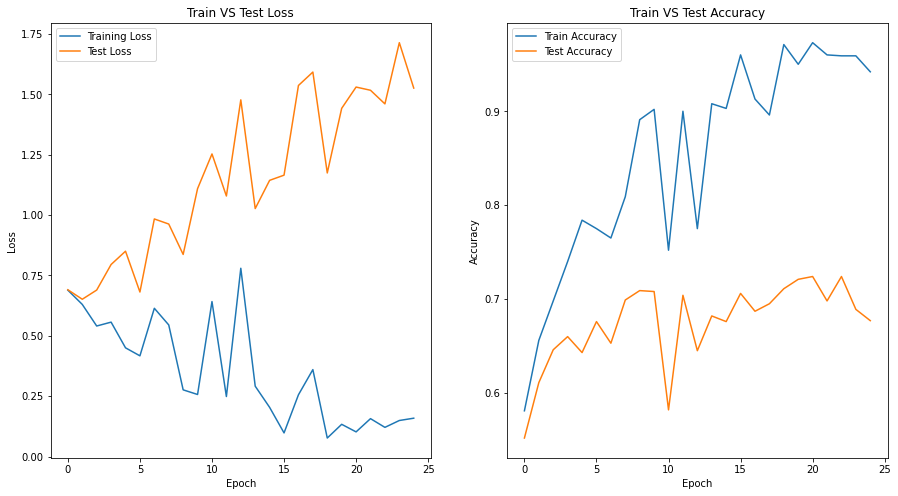

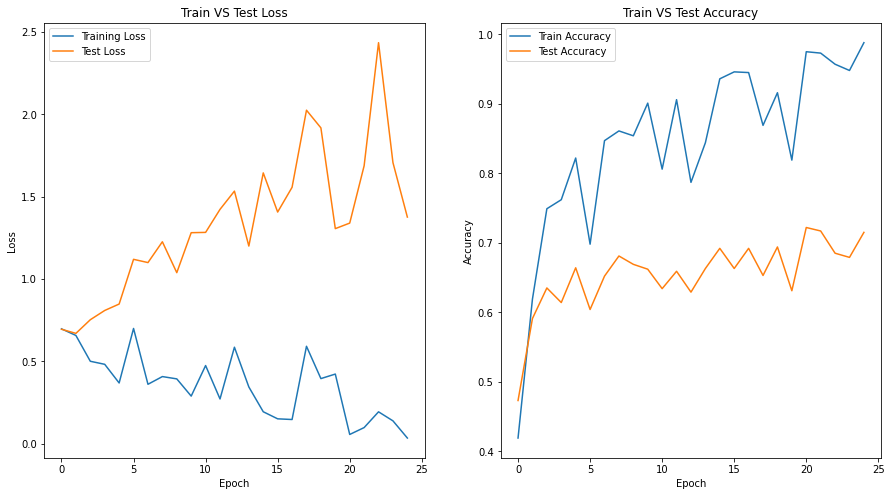

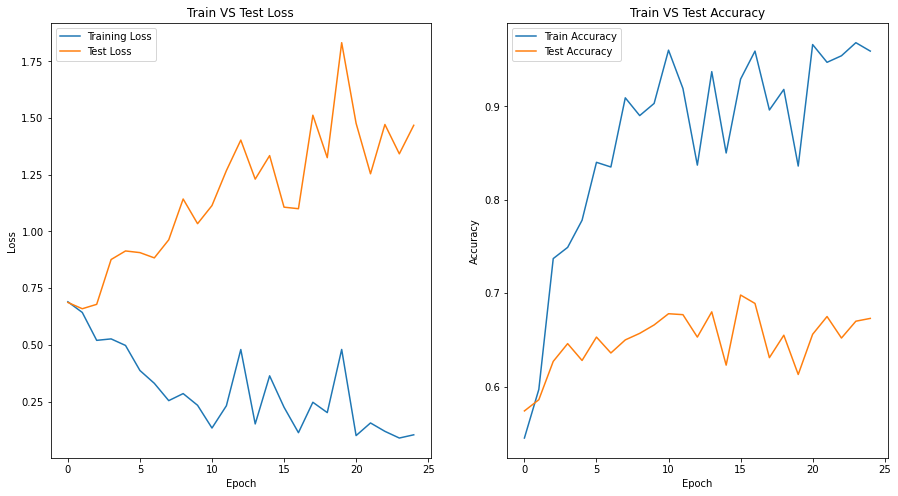

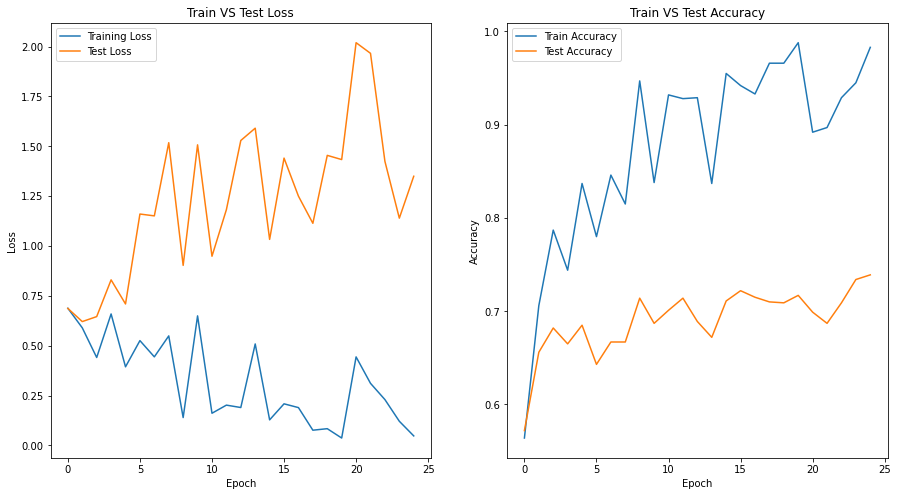

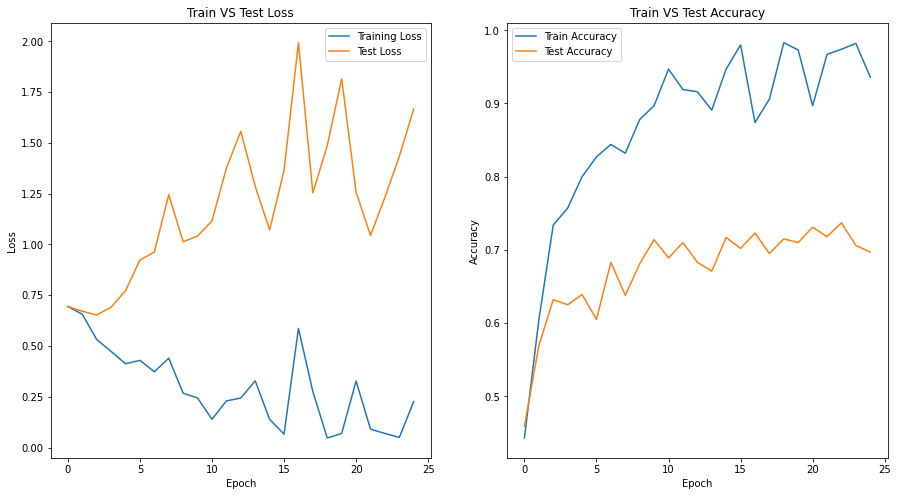

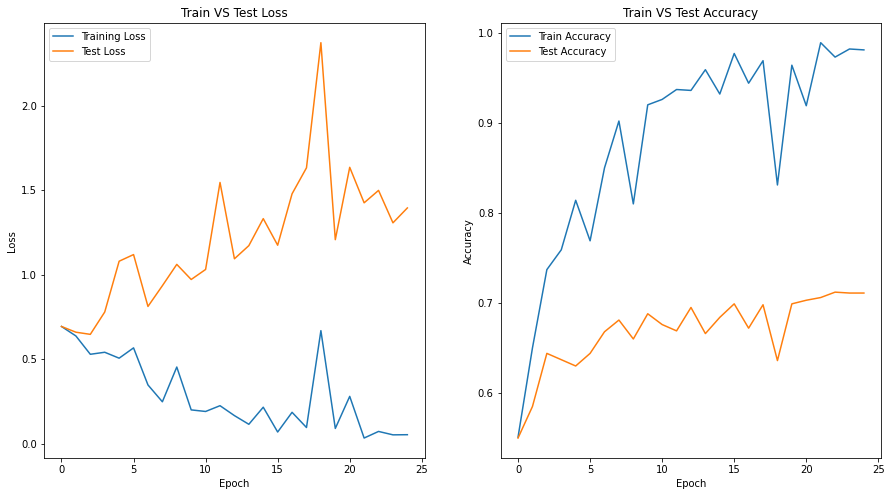

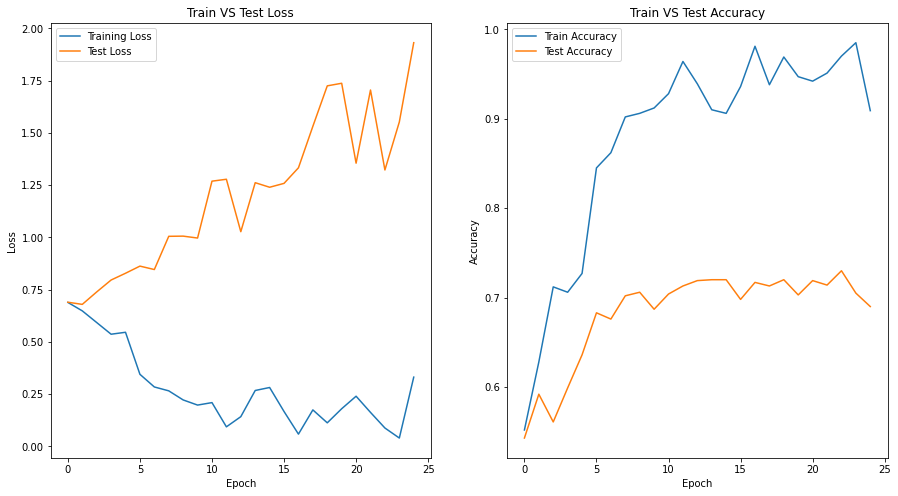

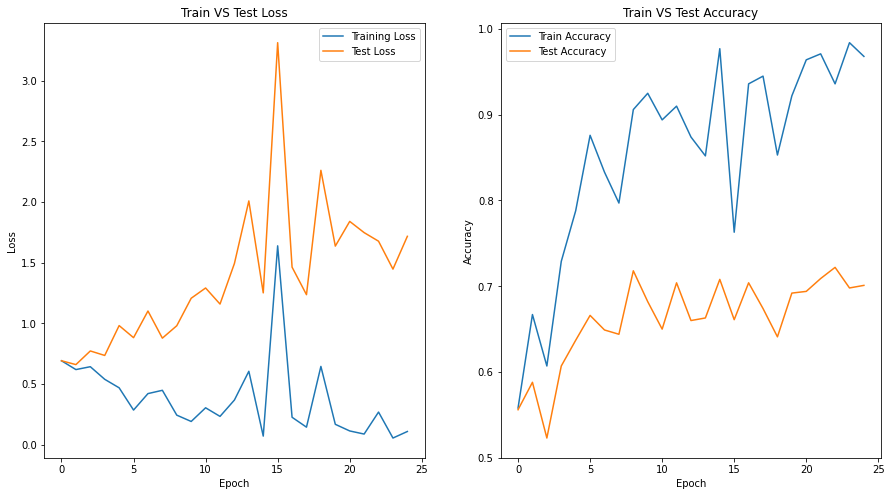

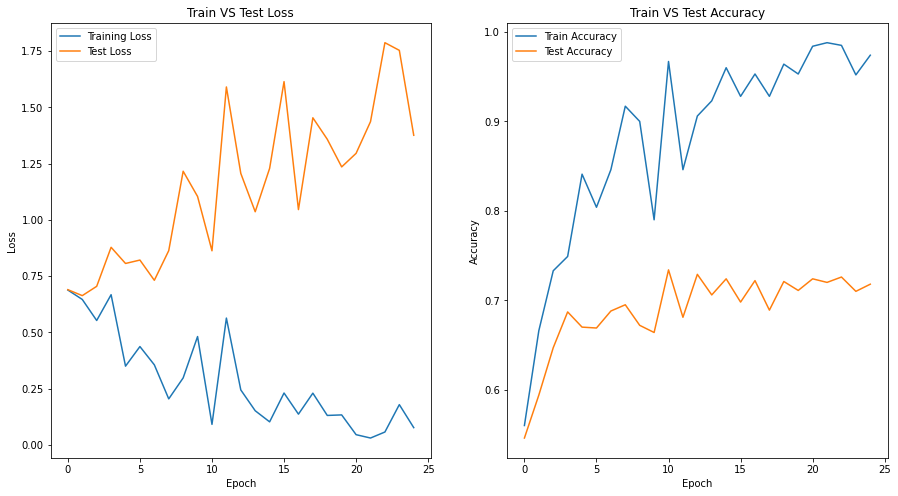

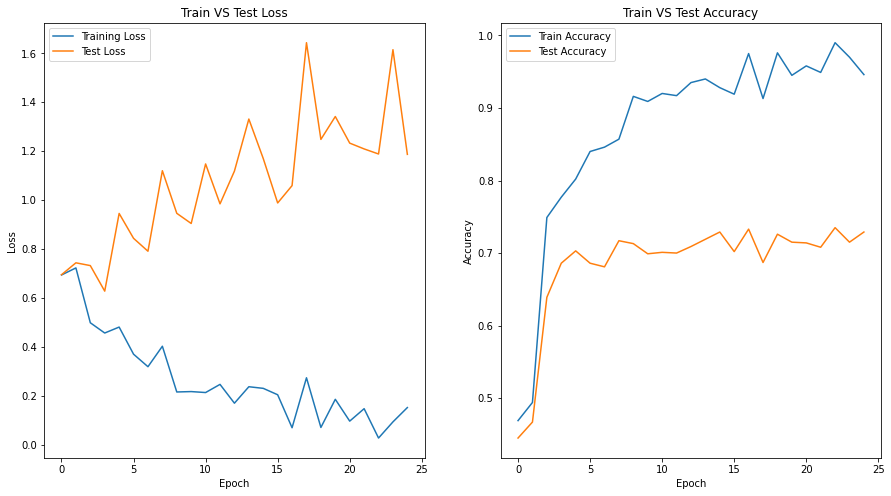

In [18]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    my_model = ResNet()
    # train the model
    my_model.trainer(train_input, train_target,test_input, test_target)
    train_errors.append(my_model.compute_error(train_input, train_target))
    test_errors.append(my_model.compute_error(test_input, test_target))

In [19]:
print('The standard deviation of train error:',np.std(train_errors))
print('The standard deviation of test error:',np.std(test_errors))
print('The mean of train error: ',np.mean(train_errors))
print('The mean of test error:',np.mean(test_errors))

The standard deviation of train error: 0.023858753173961123
The standard deviation of test error: 0.020371553351841674
The mean of train error:  0.041400015354156494
The mean of test error: 0.29500000476837157


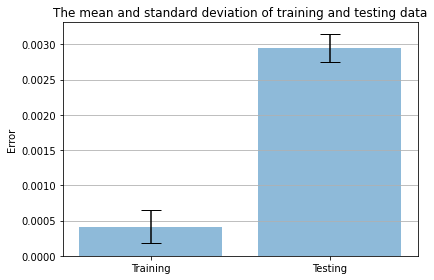

In [20]:
#plot the standard 
# Define labels, positions, bar heights and error bar heights
labels = ['Training', 'Testing']
x_pos = np.arange(len(labels))
means = [np.mean(train_errors)/100, np.mean(test_errors)/100]
stds = [np.std(np.divide(train_errors, 100)), np.std(np.divide(test_errors, 100))]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means,
       yerr=stds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('The mean and standard deviation of training and testing data')
ax.yaxis.grid(True)

# show the plot
plt.tight_layout()
plt.show()

In [ ]:
。